<a href="https://colab.research.google.com/github/dangcaptkd/temp1/blob/master/Fruit_recognition_using_color_extraction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python==3.1.0.4

     |████████████████████████████████| 6.2MB 2.8MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.1.0.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from google.colab.patches import cv2_imshow
import pandas as pd

In [ ]:
def find_contour(cnts, resized_image):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    #print(contains)
    #print(val)
    if len(val)==0:
      return 0
    return val[0]

In [ ]:
def remove_background(img):
  gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gs, (55,55),0)
  ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  kernel = np.ones((50,50),np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
  image, contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  black_img = np.empty([200,200,3],dtype=np.uint8)
  black_img.fill(0)

  index = find_contour(contours, img)
  cnt = contours[index]
  mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)

  maskedImg = cv2.bitwise_and(img, mask)

  white_pix = [255,255,255]
  black_pix = [0,0,0]

  final_img = maskedImg
  h,w,channels = final_img.shape
  for x in range(0,w):
      for y in range(0,h):
          channels_xy = final_img[y,x]
          if all(channels_xy == black_pix):    
              final_img[y,x] = white_pix
  
  return final_img

In [ ]:
#@title Nhập URL_path


path = '/content/drive/My Drive/học kì 4 uit/Fruit_60_imgs'#@param {type:"string"}
folder_name = os.listdir(path)
dataset_train = {}
dataset_test = {}
test_size = 0.25 #@param {type: "number"}
number = 1
for name in folder_name:
  print(name)
  images_train = []
  images_test = []
  for img in os.listdir(path+'/'+name):
    fruit_img = cv2.imread(path+'/'+name+'/'+img)
    resized_img = cv2.resize(fruit_img, (200, 200))
    rb_img = remove_background(resized_img)

    if len(images_test) < test_size*(len(os.listdir(path+'/'+name))):
      images_test.append(rb_img)
    else:
      images_train.append(rb_img)
    #cv2_imshow(rb_img)

    if number%10==0:
      print('done {} image'.format(number))
    number+=1

  dataset_train[name] = images_train
  dataset_test[name] = images_test

cam
done 10 image
done 20 image
cachua
done 30 image
done 40 image
chuoi
done 50 image
done 60 image


In [ ]:
def create_df_with_many_images(dataset):
  columns_name = ['name', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']
  red_means = []
  red_stds = []
  green_means = []
  green_stds = []
  blue_means = []
  blue_stds = []
  names = []
  for fruit in dataset:
    for img in dataset[fruit]:
      red_channel = img[:,:,0]
      green_channel = img[:,:,1]
      blue_channel = img[:,:,2]
      blue_channel[blue_channel == 255] = 0
      green_channel[green_channel == 255] = 0
      red_channel[red_channel == 255] = 0

      red_mean = np.mean(red_channel)
      green_mean = np.mean(green_channel)
      blue_mean = np.mean(blue_channel)
      
      red_std = np.std(red_channel)
      green_std = np.std(green_channel)
      blue_std = np.std(blue_channel)

      red_means.append(red_mean)
      red_stds.append(red_std)
      green_means.append(green_mean)
      green_stds.append(green_std)
      blue_means.append(blue_mean)
      blue_stds.append(blue_std)
      names.append(fruit)
      
  data = {'name': names, 'red_mean': red_means, 'red_std': red_stds, 'green_mean': green_means, 
          'green_std': green_stds, 'blue_mean': blue_means, 'blue_std': blue_stds}
  df = pd.DataFrame(data)
  return df

In [ ]:
df_train = create_df_with_many_images(dataset_train)
df_test = create_df_with_many_images(dataset_test)

In [ ]:
df_train.head()

,name,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,cam,40.031725,50.676539,86.514000,76.602169,109.216875,95.755464
1,cam,15.499425,38.286082,38.863300,66.041936,49.020150,82.782095
2,cam,19.140825,41.987322,44.140575,69.601869,53.836375,84.629120
3,cam,19.779125,40.612732,47.489875,69.355534,58.673200,84.952757
4,cam,19.832925,40.379143,46.742700,68.627011,58.565625,85.191895


In [ ]:
df_test.head()

,name,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,cam,21.147025,40.922773,48.791250,68.501048,63.540250,88.551137
1,cam,37.144025,54.023258,71.801650,77.016202,88.546525,94.434642
2,cam,25.183200,46.889103,61.886175,74.172450,80.664825,95.055150
3,cam,39.692550,51.343378,76.299300,75.712320,98.627475,97.260134
4,cam,44.313300,58.246593,80.317650,75.727018,100.344075,94.759164


In [ ]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [ ]:
Y_train = df_train['name']
X_train = df_train.drop(['name'], axis=1)
Y_test = df_test['name']
X_test = df_test.drop(['name'], axis=1)

In [ ]:
from collections import Counter
Counter(Y_train)

Counter({'cachua': 15, 'cam': 15, 'chuoi': 15})

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(45, 6)
(15, 6)
(45,)
(15,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [ ]:
models = []
models.append(('rfc', RandomForestClassifier()))
models.append(('svc', SVC()))
models.append(('knn', KNeighborsClassifier()))


for name, model in models:
  print(name)
  model.fit(X_train, Y_train)
  #print('\ttrain', accuracy_score(Y_train, Y_test))
  pred = model.predict(X_test)
  print('\ttest', accuracy_score(Y_test, pred))

rfc
	test 0.9333333333333333
svc
	test 0.9333333333333333
knn
	test 0.8666666666666667


In [ ]:
def create_df_with_one_img(img):
  columns_name = ['red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']
  red_means = []
  red_stds = []
  green_means = []
  green_stds = []
  blue_means = []
  blue_stds = []

  
  red_channel = img[:,:,0]
  green_channel = img[:,:,1]
  blue_channel = img[:,:,2]
  blue_channel[blue_channel == 255] = 0
  green_channel[green_channel == 255] = 0
  red_channel[red_channel == 255] = 0

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)
  
  red_std = np.std(red_channel)
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)

  red_means.append(red_mean)
  red_stds.append(red_std)
  green_means.append(green_mean)
  green_stds.append(green_std)
  blue_means.append(blue_mean)
  blue_stds.append(blue_std)

  data = {'red_mean': red_means, 'red_std': red_stds, 'green_mean': green_means, 
          'green_std': green_stds, 'blue_mean': blue_means, 'blue_std': blue_stds}
  df = pd.DataFrame(data)
  df.head()
  return df

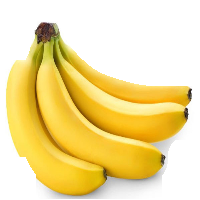

In [ ]:
img = cv2.imread('/content/chuoi.jpg')
resized_img = cv2.resize(img, (200, 200))
rb_img = remove_background(resized_img)
images.append(rb_img)
cv2_imshow(rb_img)

In [ ]:
df = create_df_with_one_img(img)
df

,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,55.089956,75.33673,120.265522,102.175172,126.375347,117.799491


In [ ]:
for name, model in models:
  pred = model.predict(df)
  print(name, pred)

rfc ['cam']
svc ['cam']
knn ['cam']
